# Ultimate Technologies, Inc.

---

Import modules.

In [1]:

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize, scale
import matplotlib.pyplot as plt
from sklearn import svm
import seaborn as sns
import pandas as pd
import numpy as np
import json

pd.options.display.max_rows = 300
pd.options.display.max_columns = 300

%matplotlib inline


Load data.

In [2]:

path = '/Users/LuisRa/Desktop/ultimate_challenge/'
challenge = 'ultimate_data_challenge.json'
logins = 'logins.json'

with open(path + challenge) as f:
    chData = json.load(f)

with open(path + logins) as f:
    logData = json.load(f)

dfCh = pd.io.json.json_normalize(chData)        
dfLog = pd.DataFrame.from_dict(logData)

print("\nSource:", challenge)
print("Rows:", dfCh.shape[0])
print("Cols:",dfCh.shape[1])

print("\nSource:", logins)
print("Rows:", dfLog.shape[0])
print("Cols:",dfLog.shape[1])



Source: ultimate_data_challenge.json
Rows: 50000
Cols: 12

Source: logins.json
Rows: 93142
Cols: 1


Prep.

In [3]:

dfLog['login_time'] = pd.to_datetime(dfLog['login_time'])
dfLog['date'] = dfLog['login_time'].dt.date
dfLog['date_mod'] = dfLog['login_time'].dt.strftime('%b %d')
dfLog['dow'] = dfLog['login_time'].dt.dayofweek
dfLog['dow_mod'] = dfLog['login_time'].dt.weekday_name

dfLog['login_time_floor'] = dfLog['login_time'].dt.floor('15min')
dfLog['time_floor'] = dfLog['login_time_floor'].dt.time
dfLog['login_time_floor'] = pd.to_datetime(dfLog['login_time_floor'])
dfLog['time_floor_mod'] = dfLog['login_time_floor'].dt.strftime('%I:%M %p')

cDate = dfLog['date'].groupby(dfLog['date']).count().to_frame()
cDate.columns = ['count']
cDate = cDate.reset_index()
cDate = pd.merge(dfLog[['date', 'date_mod']], cDate, on='date', how='inner').sort_values(by=['date'])
cDate = cDate.drop_duplicates()

cDay = dfLog['dow'].groupby(dfLog['dow']).count().to_frame()
cDay.columns = ['count']
cDay = cDay.reset_index()
cDay = pd.merge(dfLog[['dow', 'dow_mod']], cDay, on='dow', how='inner').sort_values(by=['dow'])
cDay = cDay.drop_duplicates()

cTime = dfLog['time_floor'].groupby(dfLog['time_floor']).count().to_frame()
cTime.columns = ['count']
cTime = cTime.reset_index()
cTime = pd.merge(dfLog[['time_floor', 'time_floor_mod']], cTime, on='time_floor', how='inner').sort_values(by=['time_floor'])
cTime = cTime.drop_duplicates()


### EDA: Logins

Looking at the data by date, a pattern can be observed. The number of logins tends to increase for a few days before there is a significant drop. This cycle repeats itself over and over again. Note that there is only partial data available for both the first day (Jan 1) and last day (April 13) day of activity.

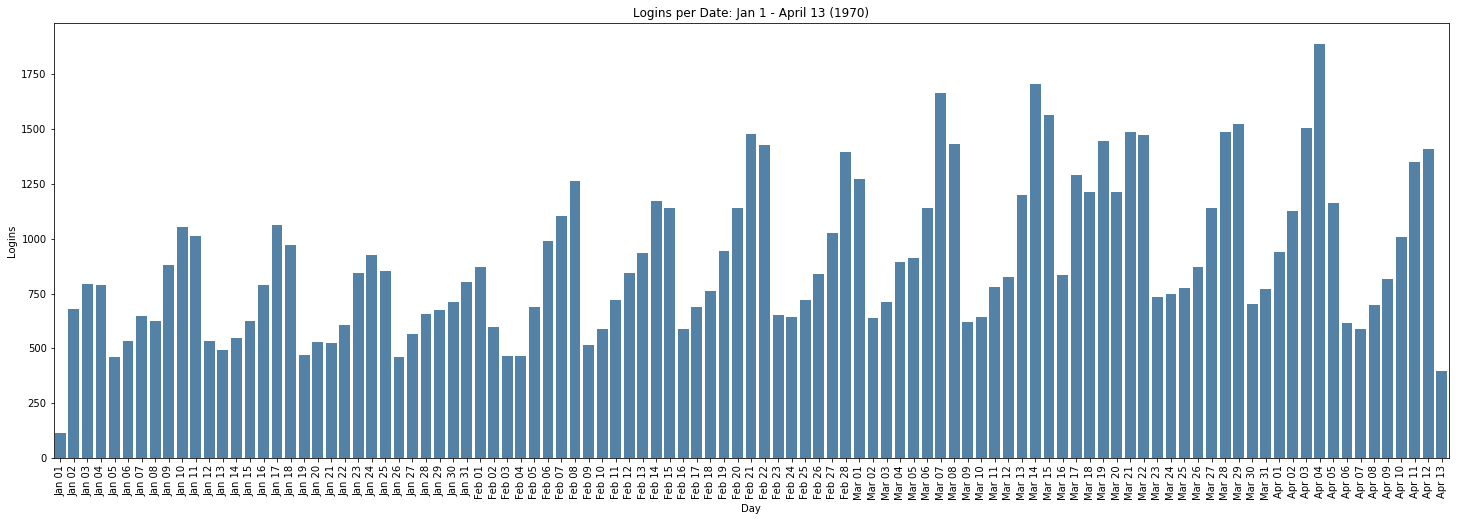


Total Logins: 93142
Avg # Logins per Date:   904


In [4]:
fig, ax = plt.subplots(figsize=(25,8))

sns.barplot(x='date', y='count', color='steelblue',
            ax=ax, data=cDate,ci=None)

ax.set_xticklabels(labels=cDate['date_mod'], rotation=90)

plt.title('Logins per Date: Jan 1 - April 13 (1970)')
plt.xlabel('Day')
plt.ylabel('Logins')

plt.show()

print("\nTotal Logins:", cDate['count'].sum())
print("Avg # Logins per Date:  ", round(cDate['count'].mean()))

From a daily standpoint, the demand increases throughout the week. This makes sense considering the weekend would be the period with most activity, as individuals would rather use this type of service instead of driving themselves. Note that Saturday is the day with the most logins, while Monday has the least.

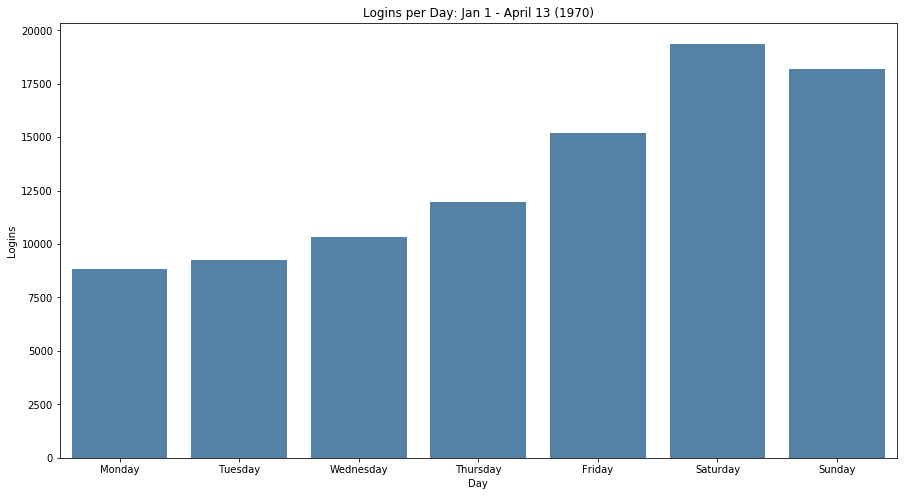


Total Logins: 93142
Avg # Logins per Day:   13306


In [5]:
fig, ax = plt.subplots(figsize=(15,8))

sns.barplot(x='dow', y='count', color='steelblue',
            ax=ax, data=cDay,ci=None)

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ax.set_xticklabels(labels=cDay['dow_mod'], rotation=0)

plt.title('Logins per Day: Jan 1 - April 13 (1970)')
plt.xlabel('Day')
plt.ylabel('Logins')

plt.show()

print("\nTotal Logins:", cDay['count'].sum())
print("Avg # Logins per Day:  ", round(cDay['count'].mean()))


Looking at 15-min intervals, another pattern can be observed (reminiscent of peak and valleys). The periods with most activity can be described as: 

* Going Home (12:00 AM - 2:00 AM)
* Lunch (10:45 AM - 12:45 PM)
* Going Out (9:45 PM - 11:45 PM)

A similar cycle to that observed by looking at the number of logins by date can be appreciated here as well. There is a period of high activity, followed by a drop and then a gradual increase until the next period of high activity is reached. Some assumptions have been made to explain this 24-hour cycle. These peaks of activity can be associated to either nightlife (both night and early morning) or lunch time.

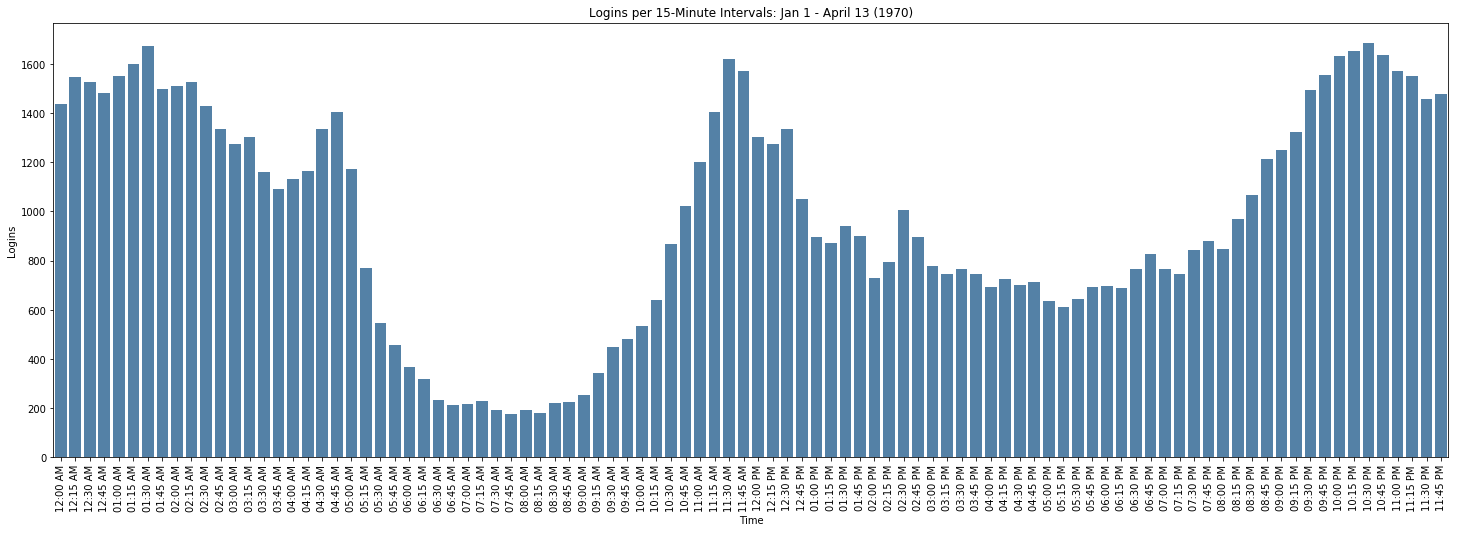


Total Logins: 93142
Avg # Logins per 15-Minute Intervals: 970


In [6]:

fig, ax = plt.subplots(figsize=(25,8))

sns.barplot(x='time_floor_mod', y='count', color='steelblue',
            ax=ax, data=cTime,ci=None)

ax.set_xticklabels(labels=cTime['time_floor_mod'].unique(), rotation=90)

plt.title('Logins per 15-Minute Intervals: Jan 1 - April 13 (1970)')
plt.xlabel('Time')
plt.ylabel('Logins')

plt.show()

print("\nTotal Logins:", cTime['count'].sum())
print("Avg # Logins per 15-Minute Intervals:", round(cTime['count'].mean()))


### Experimental and Metrics Design

What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?


I would choose number of completed trips as the key measure of success, because everything else being equal, a significant increase in the number of completed trips would suggest the driver served both cities.

---

Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

* how you will implement the experiment
* what statistical test(s) you will conduct to verify the significance of the observation
* how you would interpret the results and provide recommendations to the city operations team along with any caveats.

I would perform some type of hypothesis testing. The goal would be to test if there is a significant difference between the means of two groups, control and treatment, based on toll reimbursements and the number of completed trips. The assumption is that a significant increase in the number of completed trips would be a direct result of the reimbursements. A t-test or z-test, depending on the sample size, would be used to compare the means of the two groups.

<br>
**Breakdown**

* Population: Drivers from one of the two cities (either Gotham or Metropolis).


* Control group: Random sampling from our population, where N = some number X.


* Treatment: Random sampling from our population, where N = some number X.

Note: Toll reimbursements will apply to the treatment group.


<br>
**Recap**

* Null hypothesis: No change 

* Alternative hypothesis: Significant change 

Significance would be dictated by the p-value, where a p-value < 0.05 would be considered significant.


<br>
**Implementation**

For the same time period:

1. Measure the number of completed trips by the control group (no toll reimbursements)
2. Measure the number of completed trips by the treatment group (with toll reimbursements)
3. Compute the mean number of completed trips by both groups, grouped at some level (day, week, day of week, etc.)
4. Compare the means of the two groups using a t-test or z-test
5. Look at the p-value

<br>
If the p-value < 0.05, I would reject the null hypothesis and say the evidence indicates that toll reimbursements lead to a significant increase in the number of completed trips. I would tell the city that though the incentive works with the drivers of one city, the same hypothesis is yet to be tested with the drivers of the other one. There is also the possibility that the findings of this second experiment may not agree with the first. A third option would be to run the same experiment sampling the population of all drivers, and seeing how it compares to the findings of the previous two experiments.

---

### Predictive Modeling

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


Prep.

In [7]:
dfCh['phone'] = dfCh['phone'].fillna('None')

cSignUp = dfCh['signup_date'].value_counts().reset_index()
cSignUp.columns = ['signup_date', 'count']
cSignUp['signup_date'] = pd.to_datetime(cSignUp['signup_date'])
cSignUp['dow'] = cSignUp['signup_date'].dt.dayofweek
cSignUp['dow_mod'] = cSignUp['signup_date'].dt.weekday_name
cSignUp['signup_date_mod'] = cSignUp['signup_date'].dt.strftime('%b %d')
cSignUp = cSignUp.sort_values(by=['signup_date'])

cCityPhone = dfCh.groupby(['city','phone']).size().reset_index(name='count')
cDow = cSignUp.groupby(['dow','dow_mod']).sum().reset_index()

cFirst30 = dfCh[dfCh['trips_in_first_30_days'] > 0].shape[0]
cTripsFirst30 = dfCh['trips_in_first_30_days'].sum()


#### EDA: Riders

There's no discernible trend in the number of signups per date. It's pretty consistent. There's a hint of seasonality. Lowest # of signups was >1000, whereas the highest was ~2950.

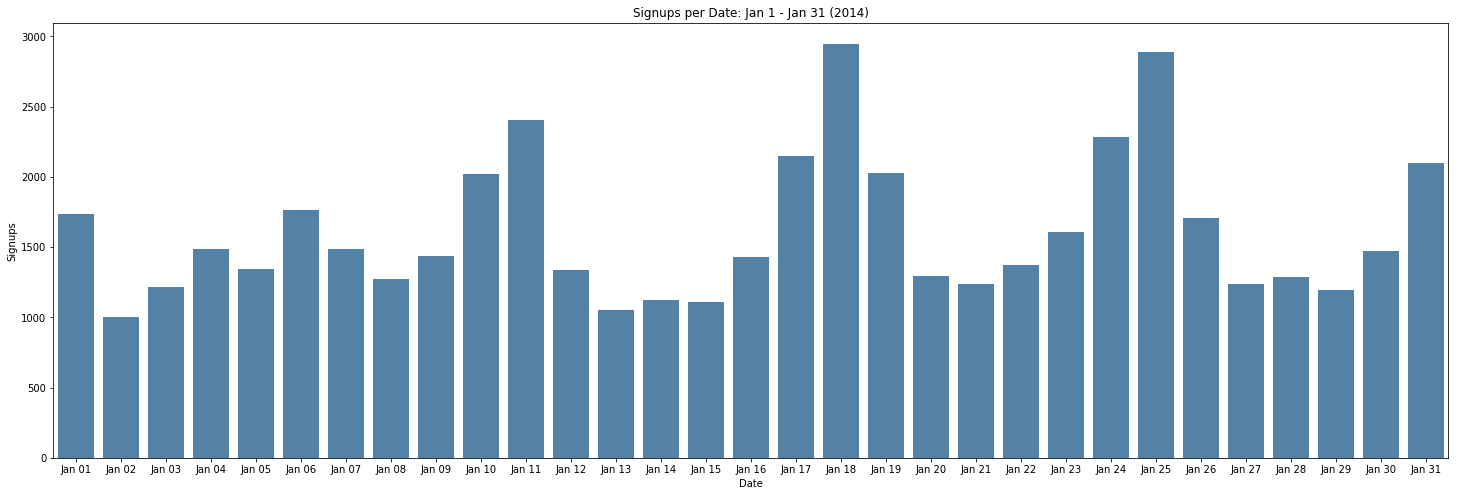


Total Signups: 50000
Avg # Signups per Date: 1612.9


In [8]:
fig, ax = plt.subplots(figsize=(25,8))

sns.barplot(x='signup_date', y='count', color='steelblue',
            ax=ax, data=cSignUp,ci=None)

ax.set_xticklabels(labels=cSignUp['signup_date_mod'], rotation=0)

plt.title('Signups per Date: Jan 1 - Jan 31 (2014)')
plt.xlabel('Date')
plt.ylabel('Signups')

plt.show()

print("\nTotal Signups:", cSignUp['count'].sum())
print("Avg # Signups per Date:", round(cSignUp['count'].mean(),2))

There's no discernible trend in the number of signups per day of the week. It's pretty consistent. Note the spike during Friday and Saturday. This makes sense, considering the weekend would be the most active period for users. Both drivers and riders have more free time.

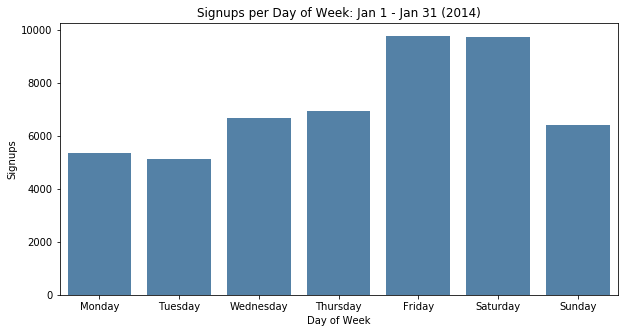


Total Signups: 50000
Avg # Signups per Day of Week: 7142.86


In [9]:
fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(x='dow', y='count', color='steelblue',
            ax=ax, data=cDow,ci=None)

ax.set_xticklabels(labels=cDow['dow_mod'].drop_duplicates(), rotation=0)

plt.title('Signups per Day of Week: Jan 1 - Jan 31 (2014)')
plt.xlabel('Day of Week')
plt.ylabel('Signups')

plt.show()

print("\nTotal Signups:", cDow['count'].sum())
print("Avg # Signups per Day of Week:", round(cDow['count'].mean(),2))

There's a significant difference in the number of signups between the three cities. Winterfell leads the way while King's Landing comes last. iPhones are also significantly more popular over Android devices among the signup population. 

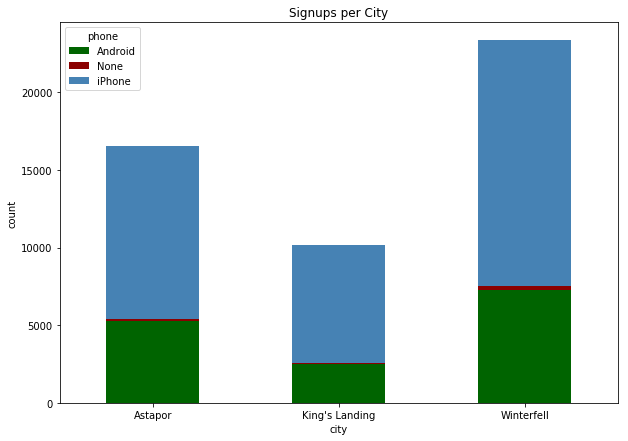


Total Signups: 50000
Avg # Signups per City: 16666.67


In [10]:
cCityPhonePiv = cCityPhone.pivot(index='city', columns='phone', values='count')

colors = ['darkgreen', 'darkred', 'steelblue']
cCityPhonePiv.plot.bar(stacked=True, color=colors, figsize=(10,7), rot=0)
plt.ylabel('count')
plt.title('Signups per City')
plt.show()

print("\nTotal Signups:", cCityPhone['count'].sum())
print("Avg # Signups per City:", round(cCityPhone.groupby(['city']).sum().reset_index().mean()[0],2))

Looking at the distribution of some of the other features per city, nothing really stands out.

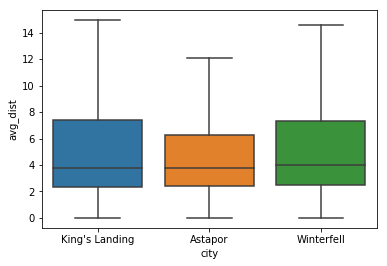

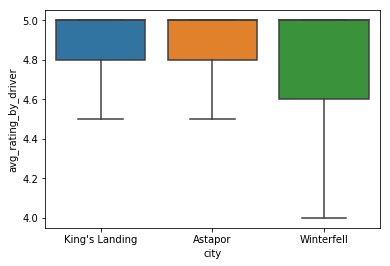

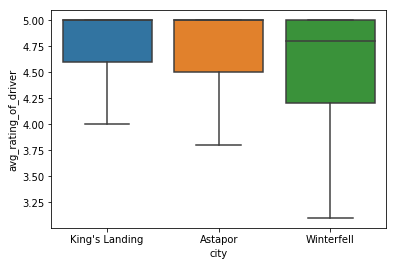

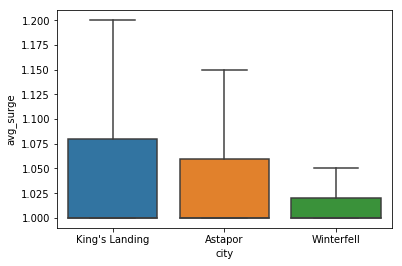

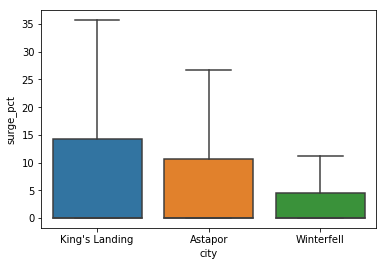

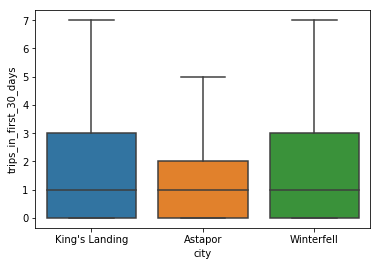

In [11]:
cols = ['avg_dist','avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct','trips_in_first_30_days']

for i,col in enumerate(cols):
    plt.figure(i)
    sns.boxplot(x="city", y="{}".format(col), showfliers = False,data=dfCh)

#### Retention

Assuming the data was pulled July 1, based on the max last trip date:

In [12]:
mxDate = dfCh['last_trip_date'].max()

dfCh['last_30'] = (pd.to_datetime(mxDate) - pd.to_datetime(dfCh['last_trip_date'])).dt.days
dfCh['retained'] = np.where(dfCh['last_30'] <= 30, 1, 0)

print('Fraction of Users Retained:')
print(round((((dfCh[dfCh['last_30'] <= 30].shape[0]) / (dfCh.shape[0]))*100),2),"%")

Fraction of Users Retained:
37.61 %


#### Modeling

Prep.

In [13]:
df_ = dfCh

#df = pd.get_dummies(df_, columns=['city', 'phone', 'ultimate_black_user',
                               #  'signup_date', 'last_trip_date'])

df = df_

df["city"] = df["city"].astype('category')
df["city_cat"] = df["city"].cat.codes

df["phone"] = df["phone"].astype('category')
df["phone_cat"] = df["phone"].cat.codes

df["ultimate_black_user"] = df["ultimate_black_user"].astype('category')
df["ultimate_black_user_cat"] = df["ultimate_black_user"].cat.codes

df = df.drop(['city','phone','ultimate_black_user', 'last_30'],axis=1)

df['signup_date'] = pd.to_datetime(df['signup_date'])
#df['signup_date_month'] = df['signup_date'].dt.month
#df['signup_date_day'] = df['signup_date'].dt.day
#df['signup_date_year'] = df['signup_date'].dt.year

df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
#df['last_trip_date_month'] = df['last_trip_date'].dt.month
#df['last_trip_date_day'] = df['last_trip_date'].dt.day
#df['last_trip_date_year'] = df['last_trip_date'].dt.year

df = df.drop(['signup_date', 'last_trip_date', 
              #'avg_rating_by_driver', 'avg_rating_of_driver'
             ], axis=1)

df = df.fillna(0)
#df = df.fillna(df.mean())

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_cat,phone_cat,ultimate_black_user_cat
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1,1,2,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0,0,0,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0,0,2,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1,1,2,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,2,0,0


In [14]:
check = df[df.isna().any(axis=1)]
print("NA records present:", check.shape[0])

NA records present: 0


In [15]:
y = dfCh['retained']
df = df.drop(['retained'],axis=1)

Decision Tree


Accuracy on Train: 0.7
Accuracy on Test: 0.71


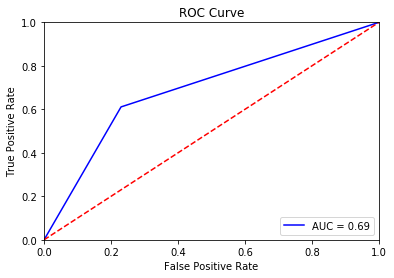


Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.77      0.77      9336
           1       0.62      0.61      0.61      5664

   micro avg       0.71      0.71      0.71     15000
   macro avg       0.69      0.69      0.69     15000
weighted avg       0.71      0.71      0.71     15000


Confusion Matrix:
         pred:1  pred:0
true:1    3461    2203
true:0    2146    7190


Feature Importance:
                    feature  importance
1                 avg_dist    0.307577
0     avg_rating_by_driver    0.179141
9              weekday_pct    0.114330
4     avg_rating_of_driver    0.081873
2                 city_cat    0.075901
3   trips_in_first_30_days    0.071808
6                surge_pct    0.058827
8                avg_surge    0.043619
7                phone_cat    0.038770
5  ultimate_black_user_cat    0.028153


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=89)
clf = DecisionTreeClassifier(random_state=89)
print('\nAccuracy on Train:', round(np.mean(cross_val_score(clf, X_train, y_train, cv=5)),2))
clf = clf.fit(X_train, y_train)

print('Accuracy on Test:', round(accuracy_score(clf.predict(X_test), y_test),2))
#print('ROC AUC Score:', round(roc_auc_score(clf.predict(X_test), y_test),2))
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('\nClassification Report:\n\n', classification_report(y_test, clf.predict(X_test)))
print('\nConfusion Matrix:\n', pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test), labels=[1, 0]), 
                                            index=['true:1', 'true:0'], columns=['pred:1', 'pred:0']))

imp = dict(zip(X_train.columns, clf.feature_importances_))
dfImp = pd.DataFrame(list(imp.items()) ,columns=['feature', 'importance'])
print('\n\nFeature Importance:\n',dfImp.sort_values(by=['importance'], ascending=False))

In [ ]:
params = dict(min_samples_split = list(range(2, 10)), #min samples to split
              max_depth = list(range(1, 10)), #max depth of tree
              min_samples_leaf = list(range(1, 10)), #min number to be a leaf
              )

clf = GridSearchCV(DecisionTreeClassifier(random_state=89), params, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

print('\nBest Estimator:\n\n',clf.best_estimator_)
print('\nBest Score:', round(clf.best_score_,2))
print('\nBest Parameters:',clf.best_params_)

clf = clf.best_estimator_
clf.fit(X_train, y_train)
dt_acc = round(accuracy_score(clf.predict(X_test), y_test),2)

print('\nAccuracy Score:', dt_acc)
print('\nClassification Report:\n\n', classification_report(y_test, clf.predict(X_test)))

Random Forest


Accuracy on Train: 0.76
Accuracy on Test: 0.76


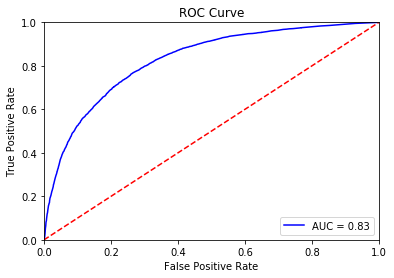


Feature Importance:

 [0.2983975  0.11692638 0.08070563 0.06795945 0.08119163 0.08170462
 0.13172234 0.0718161  0.03672147 0.03285487]

Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.82      0.81      9336
           1       0.69      0.66      0.68      5664

   micro avg       0.76      0.76      0.76     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.76      0.76      0.76     15000


Confusion Matrix:
         pred:1  pred:0
true:1    3762    1902
true:0    1716    7620


Feature Importance:
                    feature  importance
1                 avg_dist    0.298397
9              weekday_pct    0.131722
0     avg_rating_by_driver    0.116926
3   trips_in_first_30_days    0.081705
6                surge_pct    0.081192
4     avg_rating_of_driver    0.080706
2                 city_cat    0.071816
8                avg_surge    0.067959
7                phone_cat    0.036721
5  ultima

In [17]:
rf = RandomForestClassifier(n_estimators = 500, random_state = 89)
print('\nAccuracy on Train:', round(np.mean(cross_val_score(rf, X_train, y_train, cv=5)),2))
rf.fit(X_train, y_train)

print('Accuracy on Test:', round(accuracy_score(rf.predict(X_test), y_test),2))
#print('ROC AUC Score:', round(roc_auc_score(rf.predict(X_test), y_test),2))
probs = rf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("\nFeature Importance:\n\n", rf.feature_importances_)
print('\nClassification Report:\n\n', classification_report(y_test, rf.predict(X_test)))
print('\nConfusion Matrix:\n', pd.DataFrame(confusion_matrix(y_test, rf.predict(X_test), labels=[1, 0]), 
                                            index=['true:1', 'true:0'], columns=['pred:1', 'pred:0']))

imp = dict(zip(X_train.columns, rf.feature_importances_))
dfImp = pd.DataFrame(list(imp.items()) ,columns=['feature', 'importance'])
print('\n\nFeature Importance:\n',dfImp.sort_values(by=['importance'], ascending=False))

In [ ]:
params = dict(
              max_features = [None,'sqrt', 'log2'],
              n_estimators = list(range(100,1100,100)),
              criterion = ['entropy', 'gini']
             )

rf = GridSearchCV(RandomForestClassifier(random_state=89), params, cv=5, scoring='accuracy')
rf.fit(X_train, y_train)

print('\nBest Estimator:\n\n',rf.best_estimator_)
print('\nBest Score:', round(rf.best_score_,2))
print('\nBest Parameters:',rf.best_params_)

rf = rf.best_estimator_
rf.fit(X_train, y_train)
rf_acc = round(accuracy_score(rf.predict(X_test), y_test),2)

print('\nAccuracy Score:', rf_acc)
print('\nClassification Report:\n\n', classification_report(y_test, rf.predict(X_test)))

Prep.

In [19]:
X_train_ = scale(X_train)
X_test_ = scale(X_test)

/Users/LuisRa/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':
/Users/LuisRa/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by the scale function.
  from ipykernel import kernelapp as app


SVM


Accuracy on Train: 0.77
Accuracy on Test: 0.77


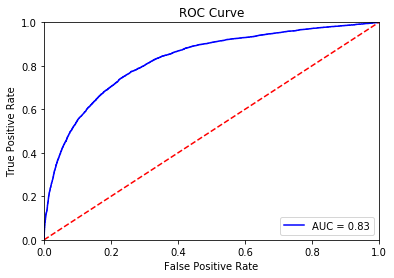


Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.88      0.83      9336
           1       0.75      0.58      0.65      5664

   micro avg       0.77      0.77      0.77     15000
   macro avg       0.76      0.73      0.74     15000
weighted avg       0.77      0.77      0.76     15000


Confusion Matrix:
         pred:1  pred:0
true:1    3287    2377
true:0    1098    8238


In [20]:

svmClf = svm.SVC(gamma='scale', probability=True)
print('\nAccuracy on Train:', round(np.mean(cross_val_score(svmClf, X_train_, y_train, cv=5)),2))
svmClf.fit(X_train_, y_train)

print('Accuracy on Test:', round(accuracy_score(svmClf.predict(X_test_), y_test),2))
#print('ROC AUC Score:', round(roc_auc_score(svmClf.predict(X_test_), y_test),2))
probs = svmClf.predict_proba(X_test_)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('\nClassification Report:\n\n', classification_report(y_test, svmClf.predict(X_test_)))
print('\nConfusion Matrix:\n', pd.DataFrame(confusion_matrix(y_test, svmClf.predict(X_test_), labels=[1, 0]), 
                                            index=['true:1', 'true:0'], columns=['pred:1', 'pred:0']))

kNN


Accuracy on Train: 0.76
Accuracy on Test: 0.76


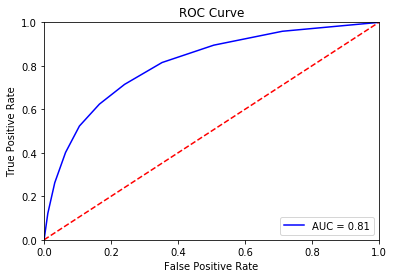


Classification Report:

               precision    recall  f1-score   support

           0       0.79      0.83      0.81      9336
           1       0.70      0.62      0.66      5664

   micro avg       0.76      0.76      0.76     15000
   macro avg       0.74      0.73      0.73     15000
weighted avg       0.75      0.76      0.75     15000


Confusion Matrix:
         pred:1  pred:0
true:1    3534    2130
true:0    1543    7793


In [21]:

knn = KNeighborsClassifier(n_neighbors=9)
print('\nAccuracy on Train:', round(np.mean(cross_val_score(knn, X_train_, y_train, cv=5)),2))
knn.fit(X_train_, y_train)

print('Accuracy on Test:', round(accuracy_score(knn.predict(X_test_), y_test),2))
#print('ROC AUC Score:', round(roc_auc_score(knn.predict(X_test_), y_test),2))
probs = knn.predict_proba(X_test_)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print('\nClassification Report:\n\n', classification_report(y_test, knn.predict(X_test_)))
print('\nConfusion Matrix:\n', pd.DataFrame(confusion_matrix(y_test, knn.predict(X_test_), labels=[1, 0]), 
                                            index=['true:1', 'true:0'], columns=['pred:1', 'pred:0']))

---
#### Conclusion

Approach: Using the max last trip date as a frame of reference, the difference between this value and the last trip date for all users was considered. If the difference was 30 or less, the user was tagged as retained. Around 37% of users were retained following this logic.

Alternatives Considered: Decision Tree, Random Forest, SVM, kNN.

Selected Model: Random Forest with an accuracy of 0.76. The f1-score of the retained users was 0.7 and that of the lost users was 0.8. For model selection, metrics considered included accuracy, precision, recall, f1-score, and auc.

Insight: The average distance in the first 30 days after signup (30%) and the weekday percent (13%) appear to be the strongest indicators of user retention. These findings suggest that engaging new users in the first 30 days, specially during a weekday, goes a long way to retaining them.
